# CS4487 Machine Learning | City University of Hong Kong
## Group Assignment - until 2019.12.13
- Tim Löhr       , EID: 40126684 
- Timo Bohnstedt , EID:

## 1.0 - Preprocessing

In [37]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt
from keras import regularizers
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from IPython.display import Image
from keras.utils.vis_utils import plot_model
import pydot
import graphviz
%matplotlib inline

In [38]:
# cifar10 category label name
cifar10_labels = np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])

### 1.1 - Load the dataset and set the labels

In [39]:
# get data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_pred = np.load("y_test.npy")

### 1.2 - Visualize the first 20 images

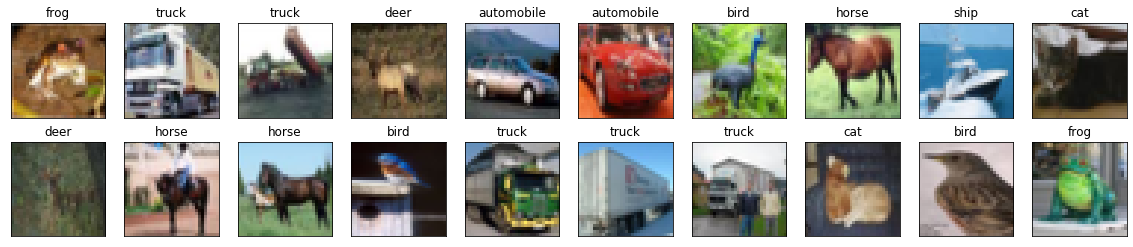

In [40]:
# show imgs
fig = plt.figure(figsize=(20, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(x_train[:20][i], cmap='gray')
    ax.set_title(cifar10_labels[y_train[:20][i].item()])

### 1.3 - Data Z-Score transformation

In [41]:
#normalization with z score
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_pred = x_pred.astype('float32')

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_pred = (x_pred-mean)/(std+1e-7)

print("X_train: " + str(x_train.shape))
print("y_train: " + str(y_train.shape))
print()
print("X_test: " + str(x_test.shape))
print("y_test: " + str(y_test.shape))

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)

X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


In [42]:
# output vector in a matrix with binary signal values 
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

### 1.4 - Predefined Functions

In [43]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [44]:
# functions
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [45]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

## 2.0 - Model
### 2.1 - VGG MOdel

In [93]:
# define model
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input, _obtain_input_shape


TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, classes=10):
   
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,  # Changed from original source to allow cifar10 data
                                      include_top=include_top,
                                     data_format=K.image_data_format())

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'cifar10':
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

In [94]:
import tensorflow as tf
print(tf.__version__)

1.10.0


In [92]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

#tf.python.control_flow_ops = tf

img_width, img_height = 32, 32
base_model = VGG16(weights='cifar10', include_top=False, input_shape=(32, 32, 3))

nb_epoch = 50
nb_classes = 10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

nb_train_samples = X_train.shape[0]
nb_validation_samples = X_test.shape[0]

# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output
# Add classification layers on top of it
x = Flatten()(last)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(10, activation='sigmoid')(x)

model = Model(base_model.input, pred)

# set the base model's layers to non-trainable
# uncomment next two lines if you don't want to
# train the base model
# for layer in base_model.layers:
#     layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

ValueError: The `weights` argument should be either `None` (random initialization) or `imagenet` (pre-training on ImageNet).

In [87]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 2.2 - VGG Model Summary

In [88]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

## 3.0 - Training
### 3.1 - Load the trained model if it exists, else train the model

In [89]:
# load or train model
exists = os.path.isfile('models/cifar10-vgg16_model.h5')
if exists:
    print('Load model...')
    #with open('model.json', 'r') as f:
      #  model = model_from_json(f.read())
    model.load_weights('models/cifar10-vgg16_model.h5')
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    print('Model loaded succesfully')
else:   
    print('Train model...')
    batch_size = 64
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                        steps_per_epoch=x_train.shape[0] // batch_size, epochs=125,\
                        verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])   
    model_json = model.to_json()
    with open('models/model_92.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('models/model_92.h5')
    print('Model saved successfully')

Load model...
Model loaded succesfully


In [90]:
from keras.models import load_model
model.load_weights('models/cifar10-vgg16_model.h5')

### 3.2 - Evaluate the Test accuracy and loss

In [91]:
model.evaluate(x_test, y_test, batch_size=128) 

ValueError: Error when checking model target: expected dense_14 to have shape (None, 10) but got array with shape (10000, 1)

In [75]:
#Evaluate    
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=128, verbose=1) 
test_loss = round(test_loss,2)
test_acc = round(test_acc,2)
print('The Test acc from our model is {:.2f}% and Loss of {}'.format(test_acc*100, test_loss))

ValueError: Error when checking model target: expected dense_10 to have shape (None, 10) but got array with shape (10000, 1)

In [31]:
plothist(history)

NameError: name 'history' is not defined

## 4.0 - Predict 12000 Image Dataset
### 4.1 Save results to CSV and print the head

In [34]:
# Predict
header = 'Index,Category'

try:
    result = pd.read_csv('results2.csv')
    print(result.head())
    print('Results loaded successfully')
except:
    y_pred = model.predict(x_pred, batch_size=128, verbose=1)
    y_pred_results = [np.argmax(x) for x in y_pred]
    print('Predict Test Data')
    np.savetxt('results2.csv',np.column_stack((np.arange(0,12000), y_pred_results)), 
               delimiter=',', fmt='%s',header=header,comments='')
    print('Saved results.csv successfully')

12000/12000 [==============================] - 41s    
Predict Test Data
Saved results.csv successfully


### 4.2 - Visualize the validation images with the predicted labels

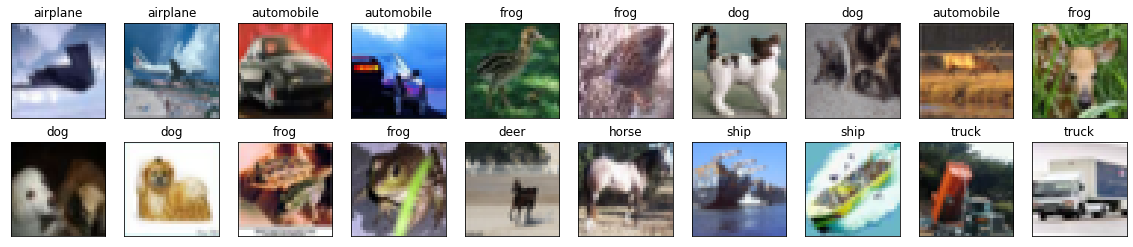

In [35]:
# show imgs
x_val = np.load("y_test.npy")

fig = plt.figure(figsize=(20, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(x_val[:2000:100][i], cmap='gray')
    ax.set_title(cifar10_labels[y_pred_results[:2000:100][i].item()])

## 5.0 Feature Map
### 5.1 - Model CNN Layers with Index

In [ ]:
# layer names and the shape of the feature maps in the layer.
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' in layer.name:
        print(i+1, layer.name, layer.output.shape)

### 5.2 - All Feature Maps of the VGG Network 

In [ ]:
# visualize the feature maps
#model = Model(inputs=model.inputs, outputs=model.layers[1].output)

square = 8
ixs = [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49]
img = x_pred[749:750]
j = 0

outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
feature_maps = model.predict(img)

for fmap in feature_maps:
    f = plt.figure(figsize=(15,10))
    ix = 1
    print()
    print('-----   Feature Map for Convolutional Layer ' + str(ixs[j]) + "   -----")
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            f.set_figheight(15)
            f.set_figwidth(15)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('Feature Map ' + str(ix))
            plt.imshow(fmap[0, :, :, ix-1])
            ix += 1
    j += 1
    plt.show()